In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
# X_train, y_train = pd.read_pickle('./data/pickle/preproc/df_patient_admit_icu__20210130_ALL_TRAIN_final.pkl')
X_train, y_train = pd.read_pickle('./data/pickle/preproc/df_patient_admit_icu_notes__20210206_singleICUSTAY_TRAIN_final.pkl')

## URGENCY SCORE

In [1]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from customTransformers import (ColumnSelectTransformer, DiagnosisFrameTransformer, 
                                EstimatorTransformer, LinearNonlinear, ColumnMergeTransformer
                               )
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

### Logistic on base cagetoricals + age, RF on diagnoses, xgboost on ensemble

In [ ]:
## TRYING TO IMPLEMENT 4 OVR CLASSIFICATION SYSTEMS FOR ICU_URGENCY.
# 1. CREATE AND TUNE OVR for demographics
# 2. use multinomial classifier for diagnoses
# 3. use all 5 outputs as features in a second multinomial to pool results
from sklearn.preprocessing import OrdinalEncoder

cols = ['GENDER','ADMISSION_TYPE','ADMISSION_LOCATION','INSURANCE','LANGUAGE',
       'RELIGION','MARITAL_STATUS','ETHNICITY']

num_cols = ['ADMIT_AGE']
demog_feats = FeatureUnion([
    ('stdscl', ColumnTransformer([('numerical', StandardScaler(), num_cols)])),
    ('ohe',  ColumnTransformer([('categorical', OneHotEncoder(handle_unknown='ignore'), cols)]))
])

demog_pipe = Pipeline([
    ('features', demog_feats),
    ('reg', LogisticRegression(solver='saga'))
])
demog_params = {
    'reg__penalty': ['l1','l2','none'],
    'reg__C': [0.01, 0.1, 1, 10],
    'reg__class_weight': ['none','balanced'],
    'reg__multi_class': ['ovr','multinomial'],
}

ordenc = OrdinalEncoder(categories=[['stable','questionable','urgent','immediate']])
y_train_enc = ordenc.fit_transform(y_train.to_numpy().reshape(-1,1))

lin_gs_classifier = GridSearchCV(demog_pipe, demog_params, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=-1)
lin_est = lin_gs_classifier.fit(X_train,y_train_enc)

lin_est.best_params_,lin_est.best_score_

In [ ]:
diagn_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer()),
    ('rfc', RandomForestClassifier())
])

diagn_params = {
    'rfc__criterion': ['gini','entropy'],
    'rfc__max_features': ['auto', 'sqrt', 'log2'],
    'rfc__min_samples_split': [2,5,8,11],
    'rfc__min_samples_leaf': [1,4,7],
    'rfc__class_weight': ['balanced', 'balanced_subsample'],
}

diagn_gs_classifier = GridSearchCV(diagn_pipe, diagn_params, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=4)
tfidf_est = diagn_gs_classifier.fit(X_train,y_train_enc)
tfidf_est.best_params_,tfidf_est.best_score_

In [ ]:
demog_est = LogisticRegression(solver='saga', C=0.1, class_weight='none', 
                               penalty='l2', multi_class='ovr')
demog_pipe = Pipeline([
    ('features', demog_feats),
    ('reg', demog_est)
])

diagn_est = RandomForestClassifier(class_weight='balanced',criterion='gini',
                                  max_features='sqrt',min_samples_leaf=1,
                                  min_samples_split=2)
diagn_pipe = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer()),
    ('rfc', diagn_est)
])

union = FeatureUnion([
    ('demog', EstimatorTransformer(demog_pipe)),# FeatureUnions use the same syntax as Pipelines
    ('diagn',EstimatorTransformer(diagn_pipe))
])


full_pipe = Pipeline([
    ('union',union),
    ('xgb', GradientBoostingClassifier())
])

xgb_params = {
    'xgb__loss': ['deviance','exponential'],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'xgb__subsample': [0.8, 1], # max is 1
    'xgb__criterion': ['friedman_mse'],
    'xgb__min_samples_leaf': [1, 4, 7],
    'xgb__max_depth': [2,3,4],
    'xgb__max_features': ['auto']
}

xgb_gs_classifier = GridSearchCV(full_pipe, xgb_params, cv=StratifiedKFold(n_splits=3, shuffle=True),verbose=3,n_jobs=4)
xgb_est = xgb_gs_classifier.fit(X_train,y_train_enc)

xgb_est.best_params_,xgb_est.best_score_

### Logistic on all features

In [4]:
cols = ['GENDER','ADMISSION_TYPE','ADMISSION_LOCATION','INSURANCE','LANGUAGE',
       'RELIGION','MARITAL_STATUS','ETHNICITY']
num_cols = ['ADMIT_AGE']

ohe = ColumnTransformer([('categorical', OneHotEncoder(handle_unknown='ignore'), cols)])
demog_feats = FeatureUnion([
    ('stdscl', ColumnTransformer([('numerical', StandardScaler(), num_cols)])),
    ('ohe',  ohe)
])

## this is for data with just diagnosis column
# count = CountVectorizer(max_features=3000)
# diagn_feats = Pipeline([
#     ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
#     ('dst', DiagnosisFrameTransformer()),
#     ('count', count),
#     ('tfid', TfidfTransformer())
# ])

## this is data with both diagnosis and notes (TEXT) columns
count = CountVectorizer(max_features=3000)
text_feats = Pipeline([
    ('cmt', ColumnMergeTransformer(['DIAGNOSIS','TEXT'])),
    ('cst', ColumnSelectTransformer(['DIAGNOSIS_TEXT'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count', count),
    ('tfid', TfidfTransformer())
])

feats_union = FeatureUnion([
    ('demog_feats', demog_feats),
    ('text_feats', text_feats)
])

lin_pipe = Pipeline([
    ('features', feats_union),
    ('reg', LogisticRegression(solver='saga'))
])

lin_params = {
    'reg__penalty': ['l1','l2'],
    'reg__C': [1, 5, 10],
    'reg__class_weight': ['none','balanced'],
    'reg__multi_class': ['ovr','multinomial'],
}

pd.set_option('mode.chained_assignment',None)
ordenc = OrdinalEncoder(categories=[['stable','questionable','urgent','immediate']])
y_train_enc = ordenc.fit_transform(y_train.to_numpy().reshape(-1,1))
lin_gs_classifier = GridSearchCV(lin_pipe, lin_params, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=2)
lin_est = lin_gs_classifier.fit(X_train,y_train_enc)

lin_est.best_params_,lin_est.best_score_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/adamgifford/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 78.1min
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed: 382.2min finished
/Users/adamgifford/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


({'reg__C': 1,
  'reg__class_weight': 'none',
  'reg__multi_class': 'ovr',
  'reg__penalty': 'l2'},
 0.6308035886488689)

In [7]:
# for diagnoses + text columns
file = './data/pickle/models/log__URGENCY__20210208_withTEXT_diagnNoNumerics.pkl'

model_data = {
    'numeric_cols': num_cols,
    'categorical_cols': cols,
    'diagnosis_col': ['DIAGNOSIS'],
    'ohe_categoricals': ohe,
    'feature_union': feats_union,
    'text_vect': text_feats,
    'ord_enc_y': ordenc,
    'gridsearch': lin_gs_classifier,
    'estimator': lin_est
}
pickle.dump(model_data,open(file,'wb'))

In [16]:
file = './data/pickle/models/log__URGENCY__20210204_diagnNoDigits.pkl'

ohe.fit(X_train)
feats_union.fit(X_train)
diagn_feats.fit(X_train)
model_data = {
    'numeric_cols': num_cols,
    'categorical_cols': cols,
    'diagnosis_col': ['DIAGNOSIS'],
    'ohe_categoricals': ohe,
    'feature_union': feats_union,
    'diagn_vect': diagn_feats,
    'ord_enc_y': ordenc,
    'gridsearch': lin_gs_classifier,
    'estimator': lin_est
}
pickle.dump(model_data,open(file,'wb'))

In [13]:
file = './data/pickle/models/log__URGENCY__20210130.pkl'
model_data = pickle.load(open(file,'rb'))
X_test, y_test = pd.read_pickle('./data/pickle/preproc/df_patient_admit_icu__20210130_ALL_TEST_final.pkl')
# X_test, y_test = pd.read_pickle('./data/pickle/preproc/df_patient_admit_icu__20210130_singleICUSTAY_TEST_final.pkl')

In [15]:
model_data['estimator'].best_params_

{'reg__C': 1,
 'reg__class_weight': 'none',
 'reg__multi_class': 'ovr',
 'reg__penalty': 'l2'}

In [70]:
est = model_data['estimator']
oh = model_data['ohe_categoricals']
dv = model_data['diagn_vect']
fu = model_data['feature_union']
ord_enc = model_data['ord_enc_y']
cats = model_data['categorical_cols']
# del model_data
# est

[[ 121  143  141  744]
 [  88  305  298  982]
 [  51  176 1052 1359]
 [  52  168  111 6403]]
0.6463014597342955
0.5928604185555643


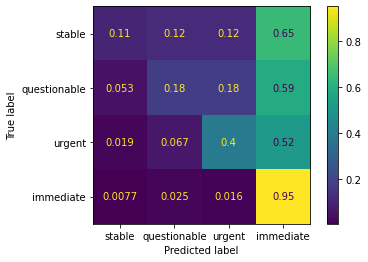

In [19]:
y_test_enc = ord_enc.transform(y_test.to_numpy().reshape(-1,1))
y_pred = est.predict(X_test)
print(confusion_matrix(y_test_enc,y_pred))
print(accuracy_score(y_test_enc,y_pred))
print(f1_score(y_test_enc,y_pred, average='weighted'))
plot_confusion_matrix(est, X_test,y_test_enc,display_labels=['stable','questionable','urgent','immediate'],normalize='true')

In [20]:
# this is true correct ix
# correct_ix = np.array([pred==true for pred,true in zip(y_pred, y_test_enc)]).ravel()

# this is pred at least as urgent as true ix
correct_ix = np.array([pred>=true for pred,true in zip(y_pred, y_test_enc)]).ravel()

urg_ix = [y in [2, 3] for y in y_test_enc]

n_true_pos = sum(correct_ix[urg_ix])
n_false_neg = sum(~correct_ix[urg_ix])
N_pos = sum(urg_ix)

DAYS_ADM_ICU = X_test['DAYS_ADM_TO_ICU']

ix_true_pos = [i and j for i,j in zip(correct_ix,urg_ix)]
ix_false_neg = [not i and j for i,j in zip(correct_ix,urg_ix)]

time_savings = (n_true_pos)/N_pos * np.mean(DAYS_ADM_ICU[ix_true_pos]) - (n_false_neg)/N_pos * np.mean(DAYS_ADM_ICU[ix_false_neg])
time_savings*24

1.6794695191350062

In [77]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Spectral4
from bokeh.layouts import Column
output_notebook()

Loading BokehJS ...

testing expected functionality for web app input

In [78]:
def make_urgency_plot(y_pred_proba):
    factors = ['stable','questionable','urgent','immediate']
    source = ColumnDataSource(data=dict(factors=factors, probs=y_pred_proba, color=Spectral4))
    
    hover = HoverTool(
        tooltips=[
            ("Level", "@factors"),
            ("Probability", "@probs"),
        ]
    )
    
    ttl = "IC-U Risk Factor: {}".format(factors[y_pred_proba.argmax()].upper())
    p = figure(x_range=factors, plot_height=250, title=ttl,
            plot_width=300, tools=[hover])

    p.vbar(x='factors', top='probs', color='color', width=0.4, source=source)

    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    p.yaxis.axis_label = 'P(category)'

    return p

In [79]:
def getFeatureNames(categorical,bow,numerical=['ADMIT_AGE']):
    feature_names = numerical
    feature_names.extend([c.split('_')[-1] for c in categorical.get_feature_names()])
    feature_names.extend(bow.get_feature_names())
    
    return feature_names

In [80]:
def createFeatureCoeffDict(coefs,features):
    feats_coeffs = [(f, c) for c,f in zip(coefs,features)]
    return feats_coeffs

In [81]:
def getMostImportantFeaturesUrg(feature_imp_urg, x_test, n_most=4):
    x_test = fu.transform(x_test).toarray()[0]
    total = sum([abs(fs[1]) for fs in feature_imp_urg])
    features_scores = [(f[0], x * f[1] / total) for x,f in zip(x_test,feature_imp_urg)]
    most_important = sorted(features_scores, key=lambda x: abs(x[1]))
    return most_important[-n_most:]

In [82]:
def make_urgency_factors_plot(most_imp_feats_urg):
    y = [m[0] for m in most_imp_feats_urg]
    x = [abs(m[1]) for m in most_imp_feats_urg]
    x = [val/max(x) for val in x]

    source = ColumnDataSource(dict(factors=y, scores=x))

    hover = HoverTool(
        tooltips=[
            ("Factor", "@factors"),
            ("Scaled Score", "@scores"),
        ]
    )
    
    p = figure(y_range=y, plot_height=250, title="Main Factors",
            plot_width=400, tools=[hover])

    p.hbar(y='factors', right='scores', height=0.4, source=source)

    p.ygrid.grid_line_color = None
    p.x_range.start = 0
    p.xaxis.visible = False
    return p

In [83]:
ix= 28 #26, 25

foo = pd.DataFrame(X_test.iloc[ix]).T
foo = foo.to_dict()
bar = {key: val for key in foo for val in foo[key].values()}
xx_test = pd.DataFrame(bar,index=[0])

y_pred = int(model_data['estimator'].predict(xx_test)[0])

y_pred_proba =  model_data['estimator'].predict_proba(xx_test)[0]

p = make_urgency_plot(y_pred_proba)
show(p)

In [84]:
feature_names_urg = getFeatureNames(oh, dv.named_steps.count,
                                    ['ADMIT_AGE'])
feature_imp_urg = createFeatureCoeffDict(\
                    est.best_estimator_.named_steps.reg.coef_[y_pred],
                                feature_names_urg)
most_imp_feats_urg = getMostImportantFeaturesUrg(feature_imp_urg, 
                                                 xx_test,4)

p_urg_factors = make_urgency_factors_plot(most_imp_feats_urg)
show(p_urg_factors)

In [ ]:
layout = Column(p, p_urg_factors)

In [51]:
figfile = './data/pickle/examples/urg_examp_ix28_20210204.pkl'
pickle.dump((y_pred_proba, most_imp_feats_urg),open(figfile,'wb'))

In [53]:
foo =DiagnosisFrameTransformer()

In [55]:
'as' in foo.stopWords

True

In [4]:
cst = ColumnSelectTransformer(['DIAGNOSIS'])
dst= DiagnosisFrameTransformer()
count = CountVectorizer(max_features=3000)

In [5]:
data = cst.fit_transform(X_train)

In [6]:
data_clean = dst.fit_transform(data)

In [7]:
data_cnt = count.fit_transform(data_clean)

In [8]:
count.get_feature_names()

['aa',
 'aaa',
 'aabuse',
 'aarunoffs',
 'ab',
 'abcess',
 'abd',
 'abdcess',
 'abdmominal',
 'abdomal',
 'abdomen',
 'abdomial',
 'abdominal',
 'abdoninal',
 'ablation',
 'abletion',
 'abmormal',
 'abnormal',
 'abnormalaties',
 'abnormalities',
 'abnormality',
 'abnormalties',
 'abominal',
 'abouse',
 'abscess',
 'abscesses',
 'absence',
 'absess',
 'abuse',
 'ac',
 'aca',
 'accending',
 'access',
 'accidemt',
 'accident',
 'accidnent',
 'account',
 'acendind',
 'acending',
 'acetabular',
 'acetabulum',
 'acetaminophen',
 'acetomengohen',
 'achalasia',
 'achalsia',
 'ache',
 'achilles',
 'achondroplasia',
 'acid',
 'acidemia',
 'acidosis',
 'acites',
 'acitic',
 'acities',
 'acoustic',
 'acquired',
 'acs',
 'acsites',
 'activation',
 'active',
 'activity',
 'acuation',
 'acut',
 'acute',
 'acuterenal',
 'addison',
 'adema',
 'ademia',
 'adenal',
 'adenexal',
 'adeno',
 'adenocarcinoma',
 'adenoid',
 'adenoidcystic',
 'adenoma',
 'adenomatous',
 'adenopathy',
 'adhesions',
 'adiposity'

In [68]:
ix=5819
data[ix]

array(['CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA'],
      dtype=object)

In [60]:
data_clean[ix]

'cad  aortic stenosis coronary artery bypass graft   avr sda'

In [85]:
feature_names_urg

['ADMIT_AGE',
 'F',
 'M',
 'ELECTIVE',
 'EMERGENCY',
 'NEWBORN',
 'URGENT',
 '** INFO NOT AVAILABLE **',
 'CLINIC REFERRAL/PREMATURE',
 'EMERGENCY ROOM ADMIT',
 'HMO REFERRAL/SICK',
 'PHYS REFERRAL/NORMAL DELI',
 'TRANSFER FROM HOSP/EXTRAM',
 'TRANSFER FROM OTHER HEALT',
 'TRANSFER FROM SKILLED NUR',
 'TRSF WITHIN THIS FACILITY',
 'Government',
 'Medicaid',
 'Medicare',
 'Private',
 'Self Pay',
 '* BE',
 '* FU',
 '** T',
 '***',
 '**SH',
 '**TO',
 '*AMH',
 '*ARA',
 '*ARM',
 '*BEN',
 '*BOS',
 '*BUL',
 '*BUR',
 '*CDI',
 '*CHI',
 '*CRE',
 '*DEA',
 '*DUT',
 '*FAR',
 '*FIL',
 '*FUL',
 '*GUJ',
 '*HUN',
 '*IBO',
 '*KHM',
 '*LEB',
 '*MAN',
 '*MOR',
 '*PER',
 '*PHI',
 '*ROM',
 '*TAM',
 '*TEL',
 '*TOI',
 '*TOY',
 '*URD',
 '*YID',
 '*YOR',
 'ALBA',
 'AMER',
 'ARAB',
 'BENG',
 'CAMB',
 'CANT',
 'CAPE',
 'ENGL',
 'ETHI',
 'FREN',
 'GREE',
 'HAIT',
 'HIND',
 'ITAL',
 'JAPA',
 'KORE',
 'LAOT',
 'MAND',
 'PERS',
 'POLI',
 'PORT',
 'PTUN',
 'RUSS',
 'SERB',
 'SOMA',
 'SPAN',
 'TAGA',
 'THAI',
 'TURK',
